In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from nufeb_tools import utils,plot,spatial
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm
from joblib import Parallel, delayed, dump,load
from datetime import datetime

In [2]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard



In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
import keras_tuner as kt
from tensorboard.plugins.hparams import api as hp

print(tf.__version__)


2.9.1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [6]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()
def collect_data(folder):
    
    try:
        a = utils.get_data(directory=str(folder))
        b = spatial.fitness_metrics(a)
        return b
    except:
        print('Error in ' + str(folder))
        return
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Total Biomass]')
  plt.legend()
  plt.grid(True)

In [7]:
DIR = Path(r'E:\fitness-prediction\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]
if Path(r'E:\fitness-prediction\saved-metrics4.pkl').is_file():
    data = pd.read_pickle(r'E:\fitness-prediction\saved-metrics4.pkl')
else:
    with ProgressParallel(n_jobs=12) as parallel:
        temp = parallel(delayed(collect_data)(folder) for folder in sorted(folders))
    data = pd.concat(temp)
    data.to_pickle(r'E:\fitness-prediction\saved-metrics4.pkl')


predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) 


In [8]:
dataset = data.dropna()

In [9]:
dataset

,mother_cell,type,Voronoi Area,IPTG,Time,Distance from center,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,...,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area,initial biomass,x,y
0,33,2,1.978817e-10,0.36692,97.222222,0.000042,18725.174159,1.068169e-05,0.000006,6.013393e-06,...,-12.021521,-12.021521,9.361819e+04,166295.456827,22.893960,24.043043,15232.0,178.418964,0.000020,0.000021
1,32,2,1.943819e-10,0.36692,97.222222,0.000047,13613.387479,2.400483e-05,0.000004,4.053653e-06,...,-12.415892,-12.415892,4.165827e+04,246691.090842,21.274511,24.831784,11924.0,309.662175,0.000048,0.000097
2,20,2,4.030559e-10,0.36692,97.222222,0.000046,7314.070579,2.989025e-05,0.000005,4.605432e-06,...,-12.288274,-12.288274,3.345573e+04,217134.916354,20.835957,24.576548,6598.0,164.700681,0.000077,0.000087
3,26,2,7.323750e-10,0.36692,97.222222,0.000035,12999.941624,1.687371e-05,0.000009,9.452322e-06,...,-11.569250,-11.569250,5.926379e+04,105794.105481,21.979507,23.138500,11925.0,131.594619,0.000028,0.000077
4,14,2,9.573191e-10,0.36692,97.222222,0.000046,21866.197226,1.254053e-05,0.000006,6.013393e-06,...,-12.021521,-12.021521,7.974144e+04,166295.456827,22.573089,24.043043,15693.0,213.345049,0.000021,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,3,1,2.044298e-09,0.02123,97.222222,0.000050,360743.295668,3.564515e-05,0.000006,5.577490e-06,...,-12.096772,-12.096772,2.805431e+04,179292.103583,20.483795,24.193543,84957.0,854.539005,0.000085,0.000085
91,4,1,6.977255e-09,0.02123,97.222222,0.000013,535526.268738,1.774832e-05,0.000003,3.361547e-06,...,-12.603109,-12.603109,5.634336e+04,297482.058654,21.878439,25.206218,118240.0,1266.849913,0.000041,0.000060
92,9,1,3.902051e-09,0.02123,97.222222,0.000038,332272.304106,8.139410e-07,0.000004,8.139410e-07,...,-12.489859,-14.021378,1.228590e+06,265629.782806,28.042756,24.979718,72333.0,590.614837,0.000016,0.000034
93,5,1,0.000000e+00,0.02123,97.222222,0.000048,577973.344035,1.815485e-05,0.000005,5.195306e-06,...,-12.167755,-12.167755,5.508171e+04,192481.459635,21.833146,24.335510,119251.0,1414.508417,0.000074,0.000009


In [10]:
predictors = list(dataset.columns.drop(['total biomass','Colony Area','mother_cell'])) 
features = dataset[predictors]
labels = dataset['total biomass']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size = 0.8, random_state = 42)
train_features


,type,Voronoi Area,IPTG,Time,Distance from center,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,initial biomass,x,y
118,1,2.463707e-10,0.07329,84.722222,0.000042,0.000009,0.000009,0.000009,0.000006,0.000007,...,-11.607118,-11.607275,-11.607275,109877.107451,109894.356584,23.214236,23.214550,543.072341,0.000091,0.000063
5,1,6.263011e-10,0.20296,97.222222,0.000027,0.000007,0.000028,0.000007,0.000011,0.000032,...,-11.807297,-10.482317,-11.807297,134228.187919,35678.979174,23.614593,20.964634,1287.282586,0.000025,0.000039
79,2,8.329344e-11,0.26394,97.222222,0.000054,0.000011,0.000012,0.000011,0.000008,0.000006,...,-11.415702,-11.372085,-11.415702,90735.285586,86862.780223,22.831403,22.744170,111.963357,0.000004,0.000020
24,1,9.241813e-11,0.73644,88.888889,0.000025,0.000002,0.000011,0.000002,0.000006,0.000007,...,-13.037323,-11.374078,-13.037323,459237.710240,87036.058693,26.074646,22.748156,566.511146,0.000069,0.000034
125,1,2.035042e-11,0.00436,82.777778,0.000053,0.000005,0.000005,0.000005,0.000006,0.000007,...,-12.246461,-12.167455,-12.246461,208242.969706,192423.722360,24.492922,24.334910,749.720358,0.000010,0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1,1.648934e-10,0.00174,94.444444,0.000035,0.000010,0.000013,0.000010,0.000009,0.000007,...,-11.527566,-11.260135,-11.527566,101474.795401,77663.045383,23.055131,22.520270,1056.180998,0.000082,0.000035
116,1,2.093778e-11,0.07329,84.722222,0.000047,0.000005,0.000013,0.000005,0.000006,0.000007,...,-12.150481,-11.258861,-12.150481,189185.043470,77564.208608,24.300962,22.517723,498.152194,0.000004,0.000046
61,1,6.273411e-10,0.39249,90.833333,0.000045,0.000002,0.000007,0.000002,0.000006,0.000008,...,-13.181685,-11.904816,-13.181685,530558.109077,147977.574928,26.363370,23.809632,839.002316,0.000072,0.000090
34,2,6.451789e-11,0.01935,97.222222,0.000044,0.000009,0.000006,0.000006,0.000015,0.000006,...,-11.636006,-12.051190,-12.051190,113097.571077,171303.209366,23.272012,24.102381,103.578116,0.000090,0.000067


In [11]:
train_features.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
type,39145.0,1.501980,0.500002,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
Voronoi Area,39145.0,21.508809,2669.148051,0.000000e+00,9.286170e-11,1.670979e-10,4.152779e-10,4.209812e+05
IPTG,39145.0,0.153854,0.229670,1.020000e-03,5.930000e-03,3.988000e-02,2.060400e-01,9.880000e-01
Time,39145.0,91.253644,5.490597,8.000000e+01,8.666667e+01,9.138889e+01,9.722222e+01,9.722222e+01
Distance from center,39145.0,0.000037,0.000014,2.236068e-07,2.740018e-05,3.871860e-05,4.750126e-05,6.887940e-05
Nearest 1,39145.0,0.000009,0.000007,3.655133e-07,4.835949e-06,7.069180e-06,1.043755e-05,7.908313e-05
Nearest 2,39145.0,0.000009,0.000006,1.920937e-07,4.982971e-06,7.152265e-06,1.028895e-05,8.659224e-05
Nearest Neighbor,39145.0,0.000006,0.000003,1.920937e-07,3.767280e-06,5.303065e-06,7.134101e-06,3.649274e-05
IC1,39145.0,0.000009,0.000004,5.294365e-06,6.304458e-06,7.104619e-06,9.252759e-06,3.315020e-05
IC2,39145.0,0.000009,0.000004,5.303813e-06,6.507337e-06,7.324856e-06,8.827368e-06,4.021472e-05


In [12]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())



[[     1.502     21.509      0.154     91.254      0.         0.
       0.         0.         0.         0.         0.         0.999
       1.         1.       209.846    825.902    825.141    210.039
     -11.85     -11.848    -12.193 172484.1   169901.55      23.7
      23.695    578.149      0.         0.   ]]


In [13]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[     1.        0.        0.07     84.72      0.        0.        0.
       0.        0.        0.        0.        1.54      1.3       1.88
     323.95   1072.29   1273.8     272.7     -11.61    -11.61    -11.61
  109877.11 109894.36     23.21     23.21    543.07      0.        0.  ]]

Normalized: [[-1.   -0.01 -0.35 -1.19  0.38  0.05  0.07  1.2  -0.65 -0.4  -0.86  1.11
   0.62  1.98  1.11  0.62  1.11  0.62  0.38  0.39  1.13 -0.46 -0.43 -0.38
  -0.39 -0.08  1.45  0.45]]


In [14]:
# HP_NUM_UNITS1 = hp.HParam('units1', hp.IntInterval(32, 64))
# HP_NUM_UNITS2 = hp.HParam('units2', hp.IntInterval(32, 64))
# HP_L2 = hp.HParam('l2_rate', hp.RealInterval(0.0, 0.2))
# # HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
# # HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
# HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([3e-1, 1e-1, 1e-2]))

# MSE = 'mean_squared_error'
# logdir = 'D:/nufeb-cyano-e-coli/logs/test/'
# #tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
#                          histogram_freq=1,
#                          write_graph=True,
#                          update_freq='epoch',
#                          embeddings_freq=1)
# stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# l2=0.1
# model = None
# model = keras.Sequential(normalizer)
# model.add(keras.layers.Dense(units=64, activation="relu",kernel_regularizer=keras.regularizers.l2(l2)))
# model.add(keras.layers.Dense(units=64, activation='relu',kernel_regularizer=keras.regularizers.l2(l2)))
# model.add(keras.layers.Dense(1))
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=.3),
#               loss='mean_squared_error',
#               metrics=['mean_squared_error'])

# model.fit(train_features, train_labels, epochs=1000, validation_split=0.2,callbacks=[tensorboard_callback,
# stop_early,
# hp.KerasCallback(logdir, hparams),  # log hparams
# ],
# )

In [15]:


# with tf.summary.create_file_writer(logdir).as_default():
#   hp.hparams_config(
#     hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2,HP_L2,HP_DROPOUT, HP_OPTIMIZER,HP_LEARNING_RATE],
#     metrics=[hp.Metric(MSE, display_name='mean_squared_error')],
#   )



In [16]:
# HP_NUM_UNITS1 = hp.HParam('units1', hp.IntInterval(32, 128))
# HP_NUM_UNITS2 = hp.HParam('units2', hp.IntInterval(32, 128))
# HP_L2 = hp.HParam('l2_rate', hp.RealInterval(0.0, 0.2))
# # HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
# # HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
# HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([3e-1, 1e-1, 1e-2]))

# MSE = 'mean_squared_error'
# logdir = "D:/nufeb-cyano-e-coli/logs/hparam_tuning/"

# def train_test_model(hparams):
#   tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
#                         histogram_freq=1,
#                         write_graph=True,
#                         write_images=True,
#                         update_freq='epoch',
#                         profile_batch=2,
#                         embeddings_freq=1)
#   stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#   model = tf.keras.models.Sequential([
#     normalizer,
#     keras.layers.Dense(hparams[HP_NUM_UNITS1], activation='relu',kernel_regularizer=keras.regularizers.l2(hparams[HP_L2])),
#     keras.layers.Dense(hparams[HP_NUM_UNITS2], activation='relu',kernel_regularizer=keras.regularizers.l2(hparams[HP_L2])),
#     #keras.layers.Dropout(hparams[HP_DROPOUT]),
#     keras.layers.Dense(1),
#   ])
#   model.compile(
#       optimizer=keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
#       loss='mean_squared_error',
#       metrics=['mean_squared_error']
#   )

#   model.fit(train_features, train_labels, epochs=100, validation_split=0.2,
#   callbacks=[tensorboard_callback,stop_early,hp.KerasCallback(logdir, hparams)]
#   )
#   _, mse = model.evaluate(test_features, test_labels)
#   test_predictions  = model.predict(test_features).flatten()
#   r2=r2_score(test_labels, test_predictions)
#   return r2,mse
# def run(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     r2,mse = train_test_model(hparams)
#     tf.summary.scalar(MSE, mse, step=1)


In [17]:
# #session_num = 0
# for num_units1 in np.arange(HP_NUM_UNITS1.domain.min_value,HP_NUM_UNITS1.domain.max_value,32):
#   for num_units2 in np.arange(HP_NUM_UNITS2.domain.min_value,HP_NUM_UNITS2.domain.max_value,32):
#     for l2_rate in np.linspace(HP_L2.domain.min_value,HP_L2.domain.max_value,10):
#         for learning_rate in HP_LEARNING_RATE.domain.values:
#           hparams = {
#               HP_NUM_UNITS1: num_units1,
#               HP_NUM_UNITS2: num_units2,
#               HP_L2: l2_rate,
#               HP_LEARNING_RATE: learning_rate,
#           }
#           #run_name = "run-%d" % session_num
#           #print('--- Starting trial: %s' % run_name)
#           print({h.name: hparams[h] for h in hparams})
#           hp.hparams(hparams)  # record the values used in this trial
#           r2,mse = train_test_model(hparams)
#           #tf.summary.scalar(MSE, mse, step=1)
#           #run(logdir + run_name, hparams)
#           #session_num += 1


In [18]:
# %tensorboard --logdir logdir

In [19]:
def model_builder(hp):
  model = None
  model = keras.Sequential(normalizer)
  #l2r = hp.Float("L2_rate", min_value=1e-4, max_value=5e-1, sampling="log")
  #,kernel_regularizer=keras.regularizers.l2(l2r)
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  model.add(keras.layers.Dense(units=hp.Int("Depth1", min_value=32, max_value=512, step=32), activation="relu"))
  model.add(keras.layers.Dense(units=hp.Int("Depth2", min_value=32, max_value=512, step=32), activation='relu'))
  #keras.layers.Dropout(hp.Float("Dropout", min_value=0, max_value=5e-1, sampling='linear')),
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  learning_rate = hp.Float("Learning_Rate", min_value=1e-4, max_value=5e-1, sampling="log")
  #learning_rate = hp.Choice('Learning_Rate', values=[5e-1, 3e-1, 1e-1,1e-2])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error'])

  return model
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_squared_error',
                     max_epochs=1000,
                     factor=3,
                     directory='../logs',
                     project_name='HPO')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


INFO:tensorflow:Reloading Oracle from existing project ../logs\HPO\oracle.json
INFO:tensorflow:Reloading Tuner from ../logs\HPO\tuner0.json


In [20]:
tuner.search(train_features, train_labels,epochs=1000, validation_split=0.2,callbacks=[keras.callbacks.TensorBoard('../logs/HPO/tb'),stop_early])

# Get the optimal hyperparameters
#09

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)


Trial 1251 Complete [00h 02m 27s]
val_mean_squared_error: 1037826176.0

Best val_mean_squared_error So Far: 985645888.0
Total elapsed time: 00h 41m 30s

Search: Running Trial #1252

Value             |Best Value So Far |Hyperparameter
384               |256               |Depth1
352               |256               |Depth2
0.1434            |0.073102          |Learning_Rate
1000              |38                |tuner/epochs
334               |13                |tuner/initial_epoch
6                 |6                 |tuner/bracket
6                 |3                 |tuner/round
1247              |1160              |tuner/trial_id

Epoch 335/1000
979/979 [==============================] - 11s 11ms/step - loss: 25441294336.0000 - mean_squared_error: 25441294336.0000 - val_loss: 1959452416.0000 - val_mean_squared_error: 1959452416.0000
Epoch 336/1000
979/979 [==============================] - 11s 11ms/step - loss: 1657245568.0000 - mean_squared_error: 1657245568.0000 - val_loss: 166389

KeyboardInterrupt: 

In [21]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [23]:
best_hps.get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'Depth1',
    'default': None,
    'conditions': [],
    'min_value': 32,
    'max_value': 512,
    'step': 32,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'Depth2',
    'default': None,
    'conditions': [],
    'min_value': 32,
    'max_value': 512,
    'step': 32,
    'sampling': None}},
  {'class_name': 'Float',
   'config': {'name': 'Learning_Rate',
    'default': 0.0001,
    'conditions': [],
    'min_value': 0.0001,
    'max_value': 0.5,
    'step': None,
    'sampling': 'log'}}],
 'values': {'Depth1': 256,
  'Depth2': 256,
  'Learning_Rate': 0.0731016779286539,
  'tuner/epochs': 38,
  'tuner/initial_epoch': 13,
  'tuner/bracket': 6,
  'tuner/round': 3,
  'tuner/trial_id': '1160'}}

In [32]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_features, train_labels,epochs=100, validation_split=0.2)

val_mean_squared_error_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mean_squared_error_per_epoch.index(max(val_mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/100
979/979 [==============================] - 10s 10ms/step - loss: 5497868288.0000 - mean_squared_error: 5497868288.0000 - val_loss: 1991423872.0000 - val_mean_squared_error: 1991423872.0000
Epoch 2/100
979/979 [==============================] - 9s 9ms/step - loss: 1599493504.0000 - mean_squared_error: 1599493504.0000 - val_loss: 1468748928.0000 - val_mean_squared_error: 1468748928.0000
Epoch 3/100
979/979 [==============================] - 10s 10ms/step - loss: 1335255168.0000 - mean_squared_error: 1335255168.0000 - val_loss: 1300213888.0000 - val_mean_squared_error: 1300213888.0000
Epoch 4/100
979/979 [==============================] - 9s 10ms/step - loss: 1269650048.0000 - mean_squared_error: 1269650048.0000 - val_loss: 1283832576.0000 - val_mean_squared_error: 1283832576.0000
Epoch 5/100
979/979 [==============================] - 9s 9ms/step - loss: 1222205440.0000 - mean_squared_error: 1222205440.0000 - val_loss: 1202755456.0000 - val_mean_squared_error: 1202755456.0000


In [24]:
model = None
model = keras.Sequential(normalizer)
#l2r = hp.Float("L2_rate", min_value=1e-4, max_value=5e-1, sampling="log")
#,kernel_regularizer=keras.regularizers.l2(l2r)
# Tune the number of units in the first Dense layer
# Choose an optimal value between 32-512
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(keras.layers.Dense(units=256, activation='relu'))
#keras.layers.Dropout(hp.Float("Dropout", min_value=0, max_value=5e-1, sampling='linear')),
model.add(keras.layers.Dense(1))

# Tune the learning rate for the optimizer
#learning_rate = hp.Choice('Learning_Rate', values=[5e-1, 3e-1, 1e-1,1e-2])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=.07),
            loss='mean_squared_error',
            metrics=['mean_squared_error'])
history=model.fit(train_features, train_labels, epochs=1000, validation_split=0.2,
callbacks=[stop_early]
)
_, mse = model.evaluate(test_features, test_labels)
test_predictions  = model.predict(test_features).flatten()
r2=r2_score(test_labels, test_predictions)


Epoch 1/1000
979/979 [==============================] - 10s 10ms/step - loss: 5237950464.0000 - mean_squared_error: 5237950464.0000 - val_loss: 2023285248.0000 - val_mean_squared_error: 2023285248.0000
Epoch 2/1000
979/979 [==============================] - 9s 10ms/step - loss: 1954282880.0000 - mean_squared_error: 1954282880.0000 - val_loss: 1642911232.0000 - val_mean_squared_error: 1642911232.0000
Epoch 3/1000
979/979 [==============================] - 9s 9ms/step - loss: 1485847936.0000 - mean_squared_error: 1485847936.0000 - val_loss: 1422547200.0000 - val_mean_squared_error: 1422547200.0000
Epoch 4/1000
979/979 [==============================] - 10s 10ms/step - loss: 1338873472.0000 - mean_squared_error: 1338873472.0000 - val_loss: 1327345152.0000 - val_mean_squared_error: 1327345152.0000
Epoch 5/1000
979/979 [==============================] - 9s 9ms/step - loss: 1237288064.0000 - mean_squared_error: 1237288064.0000 - val_loss: 1227312512.0000 - val_mean_squared_error: 1227312512.

KeyboardInterrupt: 

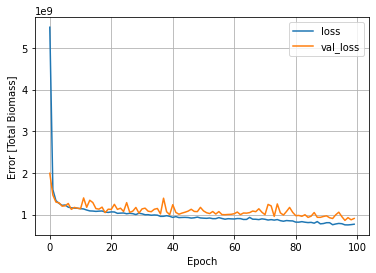

In [34]:
plot_loss(history)

306/306 [==============================] - 1s 3ms/step


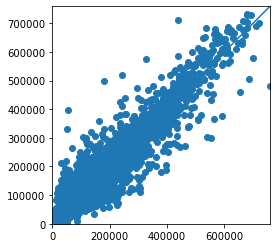

In [36]:
test_predictions  = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')

plt.scatter(test_labels, test_predictions)

lims = [0, test_labels.max()]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



In [37]:
r2_score(test_labels, test_predictions)

0.9425615237485384